In [1]:
import os
import time
import scipy
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
onColab = True
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE1/with_img_divided/moreDivision
  !ls

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1atRwyxZyj6AC5APyXg_KIP9Ghm6XZYmV/with_img_divided/moreDivision
 ckpt_mynet_trial_1_moreDivisionDS
 ckpt_mynet_trial_2_moreDivisionDS
 ckpt_mynet_trial_3_small_moreDivisionDS
'Copia di my_net.ipynb'
'Copia di mynet_trial_2.ipynb'
'Copia di on_new_ds_new_pipeline_no_hidden.ipynb'
 model.png
 mynet_trial_2_moreDivisionDS
 Second_on_new_ds_new_pipeline_no_hidden.ipynb
 training
 training.zip


In [3]:
doUnzipData = False
batch_size = 128
validation_split = 0.3

if doUnzipData:
  !unzip dataset.zip

In [4]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
dataset_path = './training'
img_h, img_w = (256, 256)
test_path = './test'


def load_data(dontUseFun=True, fun=None, isTest = False):
  """
  load data (train, val, test)
  dontUseFun: if it's true then the data is not preprocessed. If it's false, the data is preprocessed with fun (which must not be none)
  """
  image_generator = ImageDataGenerator(preprocessing_function = fun, validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  
  if dontUseFun:
    image_generator = ImageDataGenerator(validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  


  # Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
  train_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='training',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)

  valid_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='validation',
                                                batch_size=batch_size,
                                                shuffle=False,
                                                seed=seed)
  test_gen = None
  if isTest:
    test_image_gen = ImageDataGenerator(preprocessing_function = fun)
    if dontUseFun:
      test_image_gen = ImageDataGenerator(rotation_range=30)
    
    test_gen = test_image_gen.flow_from_directory(directory=test_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=True, # sometimes, instead of train, we use the test for training
                                                seed=seed)
  return train_gen, valid_gen, test_gen

In [6]:
# # we need this ONLY for the labels
train_gen = load_data(True, None, False)[0]
labels = list(train_gen.class_indices.keys())


Found 12367 images belonging to 27 classes.
Found 5282 images belonging to 27 classes.


In [7]:
print(labels)

['Apple', 'Apple_ill', 'Blueberry', 'Cherry', 'Cherry_ill', 'Corn_in', 'Corn_out', 'Grape', 'Grape_ill', 'Orange', 'Orange_ill', 'Peach', 'Peach_ill', 'Pepper', 'Pepper_ill', 'Potato', 'Potato_ill', 'Raspberry', 'Soybean', 'Soybean_ill', 'Squash', 'Squash_wild', 'Strawberry', 'Strawberry_ill', 'Strawberry_wild', 'Tomato_green', 'Tomato_others']


In [18]:
create_test_set = False

# IF YOU CHANGE NET GO CHECK THE FINE TUNING CODE IF IT IS ALRIGHT!

model_dir = 'densenet121_best_moreDivision'

# Highly dependent on the network chosen:
n_not_trainable_layers = 398

net = tfk.applications.DenseNet121


def tl_preprocess(x):
  return tf.keras.applications.densenet.preprocess_input(x)

def compute_weight(val_split):
  w = []
  for i in range(len(labels)):
    class_imgs = next(os.walk('{}/{}/'.format('./training', labels[i])))[2]
    w.append(len(class_imgs) * (1 - val_split))

  tot = sum(w)
  for i in range(len(w)):
    w[i] = tot / w[i]
  m = max(w)
  w = np.array(w) / m
  w[np.argmax(w)] = 0.99999999999999
  d = {}
  for i in range(len(w)):
    d[i] = w[i]
  return d

# weights computed for validation split = 0.3
class_weight = compute_weight(validation_split)

mappings = {
    0: 0, 1: 0,
    2: 1,
    3: 2, 4: 2,
    5: 3, 6: 3,
    7: 4, 8: 4,
    9: 5,
    10: 6, 11: 6,
    12: 7, 13: 7,
    14: 8, 15: 8,
    16: 9, 
    17: 10,
    18: 11,
    19: 12, 20: 12,
    21: 13, 22: 13
}
drop_out_last_dense = 0
fc_dense_n_neurons = 0

comment = 'densenet121, transfer learning. GAP used. no hidden dense layer with drop out'
comment += '\nnot trainable layers: ' + str(n_not_trainable_layers)
comment += ' drop_out_last_dense ' + str(drop_out_last_dense)
comment += ' fc_dense_n_neurons ' + str(fc_dense_n_neurons)
comment += '\nvalidation_split = ' + str(validation_split) 
comment += '. batch_size = ' + str(batch_size) 
comment += '. seed = ' + str(seed)
comment += '\nweigths: '
comment += str(class_weight)
print(comment)

densenet121, transfer learning. GAP used. no hidden dense layer with drop out
not trainable layers: 398 drop_out_last_dense 0 fc_dense_n_neurons 0
validation_split = 0.3. batch_size = 128. seed = 20
weigths: {0: 0.15611814345991562, 1: 0.15744680851063828, 2: 0.16554809843400448, 3: 0.2846153846153846, 4: 0.23197492163009406, 5: 0.2072829131652661, 6: 0.08820023837902265, 7: 0.24183006535947713, 8: 0.0647419072615923, 9: 0.05124653739612189, 10: 0.28030303030303033, 11: 0.2901960784313725, 12: 0.10292072322670377, 13: 0.164079822616408, 14: 0.2442244224422442, 15: 0.4157303370786517, 16: 0.1182108626198083, 17: 0.28136882129277563, 18: 0.056661562021439515, 19: 0.25517241379310346, 20: 0.13909774436090225, 21: 0.99999999999999, 22: 0.22289156626506024, 23: 0.26618705035971224, 24: 0.7708333333333335, 25: 0.1488933601609658, 26: 0.01443620756925478}


In [10]:
if create_test_set:
  import shutil
  os.mkdir(test_path)
  for i in range(len(labels)):
      class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
      # In this way we always get the same data. 
      # TODO: randomize using seed the data we take
      class_imgs.sort()
      for j in range(5):
        class_img = class_imgs[j]
        dest_dir = './test/' + labels[i] + '/'
        if not os.path.exists(dest_dir):
          os.mkdir(dest_dir)
        shutil.move('{}/{}/'.format(dataset_dir, labels[i]) + class_img, dest_dir)


In [11]:
def preprocess(x):
  # x = clean_image(x)
  if tl_preprocess:
    return tl_preprocess(np.uint8(x))
  return x

In [12]:
train_gen, valid_gen, test_gen = load_data(False, preprocess)

Found 12367 images belonging to 27 classes.
Found 5282 images belonging to 27 classes.


In [13]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(image)
  plt.title("image which will be fed to the cnn")
  return batch

# Get a sample from dataset and show info
# _ = get_next_batch(train_gen)

In [14]:
supernet =  net(
    weights="imagenet",
    input_shape=(img_h, img_w, 3),
    include_top=False
    )

29097984/29084464 [==============================] - 0s 0us/step


In [17]:
print(len(supernet.layers))

427


In [19]:
# let last block trainable
for i, layer in enumerate(supernet.layers[:n_not_trainable_layers]):
  layer.trainable=False
for i, layer in enumerate(supernet.layers):
  print(i, layer.name, layer.trainable)
# supernet.summary()

# Now we use the supernet as layer of our network
inputs = tfk.Input(shape=(img_h, img_w, 3))
x = supernet(inputs)

# Now we build our classifier (which will be actually trained)
x = tfkl.GlobalAveragePooling2D(name="avg_pool")(x)
x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    len(labels), 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

model.summary()

0 input_1 False
1 zero_padding2d False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_1 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_1_

In [28]:
c = [tfk.callbacks.ModelCheckpoint('./2ckpt_' + model_dir, save_best_only=True), tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=8, restore_best_weights=True)] 
history = model.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = 200,
    validation_data = valid_gen,
    class_weight = class_weight,
    callbacks = c
).history

Epoch 1/200
97/97 [==============================] - 403s 4s/step - loss: 0.0123 - accuracy: 0.9419 - val_loss: 0.1844 - val_accuracy: 0.9250
Epoch 2/200
97/97 [==============================] - 330s 3s/step - loss: 0.0127 - accuracy: 0.9377 - val_loss: 0.2048 - val_accuracy: 0.9207
Epoch 3/200
97/97 [==============================] - 408s 4s/step - loss: 0.0126 - accuracy: 0.9434 - val_loss: 0.1825 - val_accuracy: 0.9353
Epoch 4/200
97/97 [==============================] - 401s 4s/step - loss: 0.0123 - accuracy: 0.9407 - val_loss: 0.1776 - val_accuracy: 0.9315
Epoch 5/200
97/97 [==============================] - 320s 3s/step - loss: 0.0128 - accuracy: 0.9468 - val_loss: 0.2109 - val_accuracy: 0.9258
Epoch 6/200
97/97 [==============================] - 331s 3s/step - loss: 0.0133 - accuracy: 0.9372 - val_loss: 0.1980 - val_accuracy: 0.9246
Epoch 7/200
97/97 [==============================] - 331s 3s/step - loss: 0.0123 - accuracy: 0.9457 - val_loss: 0.2042 - val_accuracy: 0.9228
Epoch 

In [29]:
model.save('./2' + model_dir)

INFO:tensorflow:Assets written to: ./2densenet121_best_moreDivision/assets


In [ ]:
# model.evaluate(test_gen, return_dict=True)

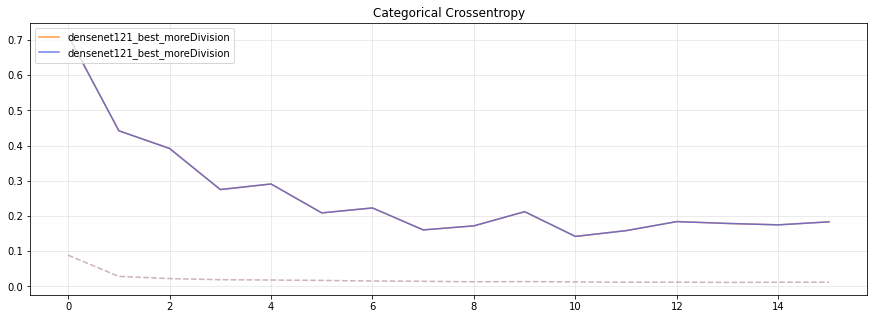

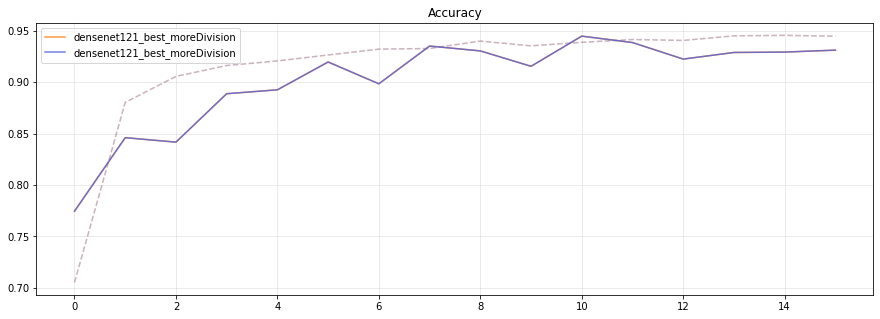

In [22]:
def compareModels(history1, h1lbl, history2=None, h2lbl=''):
  '''
  Plot history1 against history2. 
  If history2 is None then Plot twice history1 (it'll be overlapped)
  h1lbl and h2lbl are the labels of the two histories
  '''
  if history2 == None: 
    history2 = history1
    h2lbl = h1lbl
  # Plot the training
  plt.figure(figsize=(15,5))
  plt.plot(history1['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(history1['val_loss'], label=h1lbl, alpha=.8, color='#ff7f0e')
  plt.plot(history2['loss'], alpha=.3, color='#4D61E2', linestyle='--')
  plt.plot(history2['val_loss'], label=h2lbl, alpha=.8, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Categorical Crossentropy')
  plt.grid(alpha=.3)

  plt.figure(figsize=(15,5))
  plt.plot(history1['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
  plt.plot(history1['val_accuracy'], label=h1lbl, alpha=.8, color='#ff7f0e')
  plt.plot(history2['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
  plt.plot(history2['val_accuracy'], label=h2lbl, alpha=.8, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=.3)

  plt.show()
compareModels(history, model_dir)

In [ ]:
model = tf.keras.models.load_model('./' + model_dir)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_gen.classes, y_pred))

Confusion Matrix
[[ 140    0    0    0    0    0    0    0    0    0    0    2    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   1  138    0    0    1    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    1]
 [   0    0  132    0    2    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0   77    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    1    0    0    0    0    0    0    0]
 [   0    2    0    0   93    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0  107    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0  250    0    0    0    0    0    0    0
     0    0    0    0    0    0    1    0    0    0    0    0    0]
 [ 

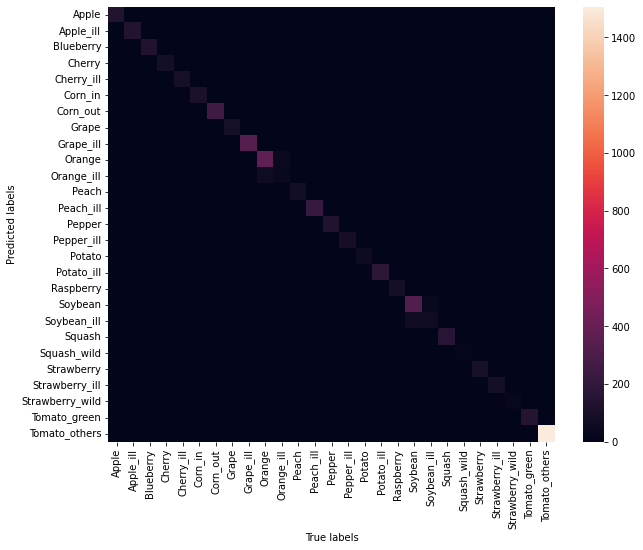

In [24]:
# Plot the confusion matrix
import seaborn as sns
cm = confusion_matrix(valid_gen.classes, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [25]:
# # Compute the classification metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
target = valid_gen.classes
predictions = Y_pred
accuracy = accuracy_score(target, np.argmax(predictions, axis=1))
precision = precision_score(target, np.argmax(predictions, axis=1), average='macro')
recall = recall_score(target, np.argmax(predictions, axis=1), average='macro')
f1 = f1_score(target, np.argmax(predictions, axis=1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

Accuracy: 0.9468
Precision: 0.9193
Recall: 0.9326
F1: 0.9249


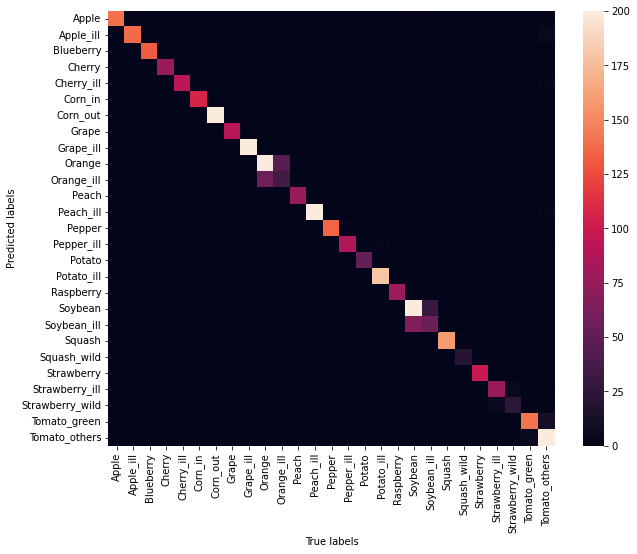

In [26]:
# Let's replot the heatmap but this time we put vmax = 200, so that tomatoes don't cloud the colors of the heatmap and we can visualize the distribution a bit better
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels, vmax=200)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()